In [1]:
import numpy as np
import pickle
import json
import os
import sys
import copy
import sklearn.preprocessing
import models
from sklearn.neighbors import NearestNeighbors
import utils
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
data='fb15k'
DATA_DIR = "../../data/"+data
DUMP_FILE = "../dumps/"+data+"_distmult_dump_norm.pkl"
MODEL_TYPE = data
# mining_dir=data+"_low_thresh"
mining_dir=data+"_rule_mining_tmp"
os.system("mkdir -p "+mining_dir)

0

In [3]:
train_data = utils.read_data(os.path.join(DATA_DIR,"train.txt"))
# dev_data = read_data(os.path.join(DATA_DIR,"valid.txt"))
# test_data = read_data(os.path.join(DATA_DIR,"test.txt"))

In [4]:
dump=utils.load_pickle(DUMP_FILE)
dump.keys()

dict_keys(['tail_rel_type', 'entity_type', 'entity_to_id', 'head_rel_type', 'entity_real', 'rel_real', 'relation_to_id'])

In [5]:
model=models.TypedDM(DUMP_FILE)

In [6]:
mapped_train_data = utils.map_data(train_data,dump)
# mapped_dev_data = map_data(dev_data)
# mapped_test_data = map_data(test_data)

In [7]:
entity_to_rel=utils.get_ent_to_rel(mapped_train_data)

In [8]:
index_head=utils.get_head_index(mapped_train_data)

# Length 1 Rules

In [9]:
relation_count=len(dump['relation_to_id'])
nbrs = NearestNeighbors(n_neighbors=relation_count,metric=model.similarity_relembedding).fit(model.relation_matrix)
print(relation_count)
count_r,set_r=utils.get_relation_dict(mapped_train_data)
print(len(count_r),len(set_r))
support=1

1345
1345 1345


In [10]:
rules_dict_1={}
count=0
count2=0
for r1 in range(relation_count):
    if(r1%100==0):
        print(r1)
    if(count_r[r1]<support):
        continue
    combined_rel=model.relation_matrix[r1].reshape((1,-1))
    distances, indices = nbrs.kneighbors(combined_rel)
    indices=indices[0]
    bool_arr=[False for i in range(relation_count)]
    for ind in indices:
        if ind!=r1:
            bool_arr[ind]=True
    cur_dict={}
    for pair_e1e2 in set_r[r1]:
        if pair_e1e2 not in entity_to_rel:
            print("Strange")
            continue
        for r2 in entity_to_rel[pair_e1e2]:
            count+=1
            if bool_arr[r2]==False:
                continue
            if r2 not in cur_dict:
                count2+=1
                cur_dict[r2]=0
            cur_dict[r2]+=1
    rules_dict_1[r1]=cur_dict            

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300


In [11]:
print(len(rules_dict_1))
print(count,count2)

1345
733548 4296


# Length 2 Rules

In [12]:
%time count_r1_r2,set_r1_r2=utils.get_r1r2_count(mapped_train_data,index_head,get_set=True)

CPU times: user 1min 2s, sys: 1.98 s, total: 1min 4s
Wall time: 1min 4s


In [13]:
nbrs = NearestNeighbors(n_neighbors=500,metric=model.similarity_relembedding).fit(model.relation_matrix)
support=1

In [14]:
count=0
rules_dict={}
for r1 in range(relation_count):
    if(r1%100==0):
        print(r1)
    for r2 in range(relation_count):
        if(r1==r2):
            continue
        pair=(r1,r2)
        if(pair not in count_r1_r2 or count_r1_r2[pair]<support):
            continue
        
        combined_rel=model.dot_relation(r1,r2).reshape((1,-1))
        distances, indices = nbrs.kneighbors(combined_rel)
        
        bool_arr=[False for i in range(relation_count)]
        for ind in indices[0]:
            if ind!=r1 and ind!=r2:
                bool_arr[ind]=True
        
        if bool_arr[r1]==True or bool_arr[r2]==True:
            print("Strange")
            print(indices[0],r1,r2)
        
        cur_dict={}
        entpair_lis=list(set_r1_r2[pair])
        for pair_e1e2 in entpair_lis:
            if pair_e1e2 not in entity_to_rel:
                continue
            for r in entity_to_rel[pair_e1e2]:
                if(bool_arr[r]==False):
                    continue
                if r not in cur_dict:
                    count+=1
                    cur_dict[r]=0
                cur_dict[r]+=1
        rules_dict[pair]=cur_dict
        

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300


In [16]:
print(len(rules_dict))
print(relation_count)
print(count)

56651
1345
9328


# Saving rules

In [17]:
path1='1_sup=1.pkl'
path1=os.path.join(mining_dir,path1)
utils.dump_pickle(rules_dict_1,path1)
print(len(rules_dict_1))

1345


In [18]:
path2='2_sup=1_nei=500.pkl'
path2=os.path.join(mining_dir,path2)
utils.dump_pickle(rules_dict,path2)
print(len(rules_dict))

56651


## Saving auxilary data for rule2

In [19]:
path='set_r1_r2.pkl'
path=os.path.join(mining_dir,path)
set_len_r1_r2={}
for r1r2 in set_r1_r2:
    set_len_r1_r2[r1r2]=len(set_r1_r2[r1r2])
utils.dump_pickle(set_len_r1_r2,path)

In [20]:
print(len(count_r1_r2))

56863


## Analyse 3 Rules

In [21]:
rules_3=[]
count=0
count_dict={}

for r1r2 in set_r1_r2:
    count+=1
    if(count%100==0):
        print(count)
    for e1e2 in set_r1_r2[r1r2]:
        e1=e1e2[0]
        e2=e1e2[1]
        # e1-r1-e-r2-e2
        count_conf_dict={}
        
        # e1-r1-e-r2-e2-r3-e3
        if e2 not in index_head:
            continue
        for r3e3 in index_head[e2]:
            e3=r3e3[1]
            triplet=(r1r2[0],r1r2[1],r3e3[0])
            if triplet not in count_dict:
                count_dict[triplet]=0
                count_conf_dict[triplet]={}
            count_dict[triplet]+=1
            

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

In [22]:
print(len(count_dict))

1646816


In [23]:
value_list=list(count_dict.values())
cnt=Counter(value_list)
cnt=sorted(cnt.items())
array=np.array(cnt)
print(array.shape)

(30878, 2)


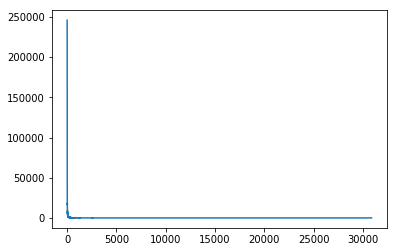

In [24]:
plt.plot(array[:,1])
plt.show()

In [25]:
temp=np.cumsum(array[:,1])/np.sum(array[:,1])
print(array[temp[:]<0.5],temp[temp[:]<0.5])

[[     1 245846]
 [     2 152144]
 [     3  90897]
 [     4  82622]
 [     5  51253]
 [     6  55643]
 [     7  34044]
 [     8  38312]
 [     9  28950]
 [    10  29029]] [0.14928565 0.24167242 0.29686802 0.34703877 0.37816125 0.41194948
 0.4326221  0.45588639 0.47346577 0.49109312]


## Rules Length 3

In [26]:
min_sup=4
confidence=0
r1r2_ent=utils.get_r1r2_e1e2_dict(mapped_train_data,index_head)

In [27]:
rules_3=[]
count=0

for r1r2 in set_r1_r2:
#     prit(r1r2)
    count+=1
    if(count%100==0):
        print(count)
        print(len(rules_3))
    for e1e2 in set_r1_r2[r1r2]:
        e1=e1e2[0]
        e2=e1e2[1]
        # e1-r1-e-r2-e2
        e=r1r2_ent[r1r2][e1e2]
        count_conf_dict={}
        count_dict={}
        
        # e1-r1-e-r2-e2-r3-e3
        if e2 not in index_head:
            continue
        for r3e3 in index_head[e2]:
            e3=r3e3[1]
            triplet=(r1r2[0],r1r2[1],r3e3[0])
            if triplet not in count_dict:
                count_dict[triplet]=0
                count_conf_dict[triplet]={}
            count_dict[triplet]+=1
            
            pair=(e1,e3)
            if pair not in entity_to_rel:
                continue
            for rel in entity_to_rel[pair]:
                if rel not in count_conf_dict[triplet]:
                    count_conf_dict[triplet][rel]=0
                count_conf_dict[triplet][rel]+=1
        
        for r1r2r3,supp in count_dict.items():
            if supp < min_sup:
                continue
            for r4,conf in count_conf_dict[r1r2r3].items():
                if conf>confidence:
                    rules_3.append((r1r2r3,r4,supp,conf))           
        

100
14232215
200
18987259
300
21947062
400
23150992
500
29728219
600
30276402
700
37909088
800
44092089
900
44939708
1000
47069193
1100
51455425
1200
51986955
1300
52600648
1400
54365371
1500
54501213
1600
54892534
1700
55753522
1800
56150236
1900
56461737
2000
56649217
2100
57209998
2200
58105190
2300
65047760
2400
66176020
2500
67518965
2600
68010237
2700
68407747
2800
70014669
2900
73422589
3000
80044413
3100
80251715
3200
81059597
3300
81148649
3400
81747942
3500
81954108
3600
82289010
3700
83252630
3800
83649691
3900
83894085
4000
84802705
4100
85007538
4200
85548516
4300
86191923
4400
86374327
4500
86562613
4600
86685004
4700
86877817
4800
87108167
4900
87222440
5000
87297777
5100
87736544
5200
88812041
5300
89603174
5400
89908768
5500
90178467
5600
90309571
5700
90408346
5800
90592727
5900
90708833
6000
90792645
6100
90845131
6200
91011627
6300
91129011
6400
91177289
6500
91208323
6600
91307869
6700
91361690
6800
91477317
6900
91598817
7000
91699882
7100
91718836
7200
91829123
7

53600
102909705
53700
102910017
53800
102910423
53900
102910686
54000
102911533
54100
102911958
54200
102912157
54300
102912545
54400
102912938
54500
102913194
54600
102913531
54700
102914254
54800
102914937
54900
102915104
55000
102915552
55100
102915824
55200
102916233
55300
102916392
55400
102917652
55500
102918460
55600
102919082
55700
102919543
55800
102920501
55900
102920801
56000
102920968
56100
102921348
56200
102921533
56300
102922783
56400
102923231
56500
102923613
56600
102923920
56700
102925774
56800
102926310


In [28]:
rules_3.sort(key=lambda x:(x[3]*1.0)/x[2],reverse=True)

In [29]:
path_rule_3=os.path.join(mining_dir,"3_sup=4_conf=0.pkl")

In [30]:
utils.dump_pickle(rules_3,path_rule_3)

## Load Len 3 rules

In [31]:
rules_3=utils.load_pickle(path_rule_3)

In [32]:
rules_3[0:10]

[((0, 108, 132), 124, 7, 7),
 ((0, 108, 41), 41, 7, 7),
 ((0, 108, 419), 124, 6, 6),
 ((0, 108, 419), 419, 6, 6),
 ((0, 108, 97), 97, 5, 5),
 ((0, 108, 132), 124, 6, 6),
 ((0, 108, 419), 419, 4, 4),
 ((0, 108, 323), 323, 9, 9),
 ((0, 108, 28), 28, 9, 9),
 ((0, 108, 102), 102, 6, 6)]

In [33]:
print(len(rules_3))

102926374


In [34]:
len(rules_3)

102926374

In [35]:
min_sup

4